# Face mask detection (Faster R-CNN) (Pytorch)
- Simple fine-tuning with Faster R-CNN

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import all the tools we need
import urllib
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image
import random
import xml.etree.ElementTree as ET
import time
import requests

In [ ]:
# path of images directory
dir_path = '/content/drive/MyDrive/Kaggle/images'

# path of xml files directory
xml_path = '/content/drive/MyDrive/Kaggle/annotations'

# List of Image file name
file_list = os.listdir(dir_path)

# How many image files?
print('There are total {} images.'.format(len(file_list)))

There are total 853 images.


### Create 2 helper functions
1. one for read the data from xml file
2. the second function is used for drawing bounding boxes.

In [ ]:
# Helper function for read the data (label and bounding boxes) from xml file
def read_annot(file_name, xml_dir):
    """
    Function used to get the bounding boxes and labels from the xml file
    Input:
        file_name: image file name
        xml_dir: directory of xml file
    Return:
        bbox : list of bounding boxes
        labels: list of labels
    """
    bbox = []
    labels = []

    annot_path = os.path.join(xml_dir, file_name[:-3]+'xml')
    tree = ET.parse(annot_path)
    root = tree.getroot()
    for boxes in root.iter('object'):
        ymin = int(boxes.find("bndbox/ymin").text)
        xmin = int(boxes.find("bndbox/xmin").text)
        ymax = int(boxes.find("bndbox/ymax").text)
        xmax = int(boxes.find("bndbox/xmax").text)
        label = boxes.find('name').text
        bbox.append([xmin,ymin,xmax,ymax])
        if label == 'with_mask':
            label_idx = 2
        elif label == 'mask_weared_incorrect':
            label_idx = 0
        else:
            label_idx = 1
        labels.append(label_idx)

    return bbox, labels

# help function for drawing bounding boxes on image
def draw_boxes(img, boxes,labels, thickness=1):
    """
    Function to draw bounding boxes
    Input:
        img: array of img (h, w ,c)
        boxes: list of boxes (int)
        labels: list of labels (int)

    """
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    for box,label in zip(boxes,labels):
        box = [int(x) for x in box]
        if label == 2:
            color = (0,225,0) # green
        elif label == 1:
            color = (0,0,225) # red
        elif label == 0:
            color = (0,34,0)
        cv2.rectangle(img, (box[0],box[1]),(box[2],box[3]),color,thickness)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

- After createing helper function, lets have a look on the image.

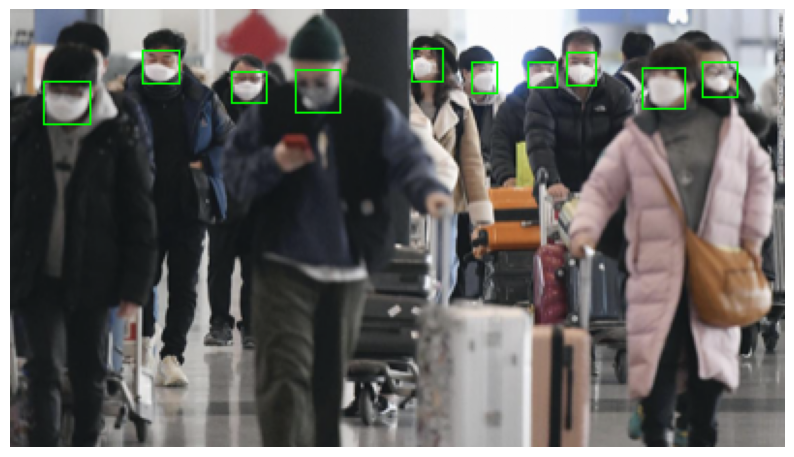

In [ ]:
# Get the image randomly
image_name = file_list[random.randint(0,len(file_list))] # random select an image

# Get the bbox and label
bbox, labels  = read_annot(image_name, xml_path)

#draw bounding boxes on the image
img = draw_boxes(plt.imread(os.path.join(dir_path,image_name)), bbox,labels)

# display the image
fig, ax = plt.subplots(1,1,figsize=(10,10))
plt.axis('off')
ax.imshow(img)

In [ ]:
labels

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

- Now lets create our custom dataset
## Prepare the custom dataset

In [ ]:
class image_dataset(Dataset):
    def __init__(self, image_list, image_dir, xml_dir):
        self.image_list = image_list
        self.image_dir = image_dir
        self.xml_dir = xml_dir

    def __getitem__(self, idx):
        """
        Load the image
        """
        img_name = self.image_list[idx]
        img_path = os.path.join(self.image_dir, img_name)
        img = Image.open(img_path).convert('RGB')
        img = transforms.ToTensor()(img)

        """
        build the target dict
        """
        bbox, labels = read_annot(img_name, self.xml_dir)
        boxes = torch.as_tensor(bbox, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        area = (boxes[:,2] - boxes[:,0]) * (boxes[:,3] - boxes[:,1])
        area = torch.as_tensor(area, dtype=torch.float32)
        iscrowd = torch.zeros((len(bbox),), dtype=torch.int64)

        target = {}

        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([idx])
        target['area'] = area
        target['iscrowed'] = iscrowd
        return img , target

    def __len__(self):
        return len(self.image_list)

- Get the data loader

In [ ]:
mask_dataset = image_dataset(file_list, dir_path, xml_path)

def collate_fn(batch):
    return tuple(zip(*batch))

mask_loader = DataLoader(mask_dataset,
                        batch_size=2,
                        shuffle=True,
                        num_workers=2,
                        collate_fn=collate_fn)

- Setting up the gpu, model, optimizer, etc..

In [ ]:
# Setting up GPU device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
# Setting up the model

num_classes = 4 # background, without_mask, with_mask

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 140MB/s]


In [ ]:
# Setting the optimizer, lr_scheduler, epochs

params = [p for p in model.parameters() if p.requires_grad]
#optimizer = torch.optim.Adam(params, lr=0.001)
optimizer = torch.optim.SGD(params, lr=0.001,momentum=0.9, weight_decay=0.0005)
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=0.1)
num_epochs = 20

In [ ]:

# Main training function
loss_list = []

for epoch in range(num_epochs):
    print('Starting training....{}/{}'.format(epoch+1, num_epochs))
    loss_sub_list = []
    start = time.time()
    for images, targets in mask_loader:
        images = list(image.to(device) for image in images)
        targets = [{k:v.to(device) for k,v in t.items()} for t in targets]

        model.train()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        loss_sub_list.append(loss_value)

        # update optimizer and learning rate
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        #lr_scheduler.step()
    end = time.time()

    #print the loss of epoch
    epoch_loss = np.mean(loss_sub_list)
    loss_list.append(epoch_loss)
    print('Epoch loss: {:.3f} , time used: ({:.1f}s)'.format(epoch_loss, end-start))


Starting training....1/20
Epoch loss: 0.381 , time used: (332.6s)
Starting training....2/20
Epoch loss: 0.256 , time used: (275.0s)
Starting training....3/20
Epoch loss: 0.225 , time used: (273.6s)
Starting training....4/20
Epoch loss: 0.204 , time used: (274.9s)
Starting training....5/20
Epoch loss: 0.183 , time used: (271.6s)
Starting training....6/20
Epoch loss: 0.170 , time used: (272.4s)
Starting training....7/20
Epoch loss: 0.155 , time used: (272.2s)
Starting training....8/20
Epoch loss: 0.144 , time used: (272.4s)
Starting training....9/20
Epoch loss: 0.135 , time used: (273.6s)
Starting training....10/20
Epoch loss: 0.122 , time used: (275.5s)
Starting training....11/20
Epoch loss: 0.114 , time used: (273.3s)
Starting training....12/20
Epoch loss: 0.106 , time used: (272.3s)
Starting training....13/20
Epoch loss: 0.101 , time used: (272.0s)
Starting training....14/20
Epoch loss: 0.096 , time used: (273.1s)
Starting training....15/20
Epoch loss: 0.091 , time used: (276.2s)
Star

In [ ]:
# Main training function
loss_list = []

for epoch in range(num_epochs):
    print('Starting training....{}/{}'.format(epoch+1, num_epochs))
    loss_sub_list = []
    start = time.time()
    for images, targets in mask_loader:
        images = list(image.to(device) for image in images)
        targets = [{k:v.to(device) for k,v in t.items()} for t in targets]

        model.train()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        loss_sub_list.append(loss_value)

        # update optimizer and learning rate
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        #lr_scheduler.step()
    end = time.time()

    #print the loss of epoch
    epoch_loss = np.mean(loss_sub_list)
    loss_list.append(epoch_loss)
    print('Epoch loss: {:.3f} , time used: ({:.1f}s)'.format(epoch_loss, end-start))


Starting training....1/45
Epoch loss: 0.387 , time used: (166.8s)
Starting training....2/45
Epoch loss: 0.269 , time used: (60.3s)
Starting training....3/45
Epoch loss: 0.224 , time used: (68.3s)
Starting training....4/45
Epoch loss: 0.205 , time used: (78.4s)
Starting training....5/45
Epoch loss: 0.185 , time used: (82.2s)
Starting training....6/45
Epoch loss: 0.173 , time used: (88.2s)
Starting training....7/45
Epoch loss: 0.159 , time used: (92.7s)
Starting training....8/45
Epoch loss: 0.156 , time used: (95.1s)
Starting training....9/45
Epoch loss: 0.155 , time used: (99.7s)
Starting training....10/45
Epoch loss: 0.138 , time used: (104.1s)
Starting training....11/45
Epoch loss: 0.134 , time used: (108.4s)
Starting training....12/45
Epoch loss: 0.127 , time used: (110.0s)
Starting training....13/45
Epoch loss: 0.124 , time used: (113.3s)
Starting training....14/45
Epoch loss: 0.137 , time used: (117.2s)
Starting training....15/45
Epoch loss: 0.119 , time used: (123.1s)
Starting tra

In [ ]:
cd /content/drive/MyDrive/Kaggle/

/content/drive/MyDrive/Kaggle


In [ ]:
torch.save(model,'model_20_epochs.pth')

# Prediction

In [ ]:
# helper function for single image prediction
def single_img_predict(img, nm_thrs = 0.3, score_thrs=0.8):
    test_img = transforms.ToTensor()(img)
    model.eval()

    with torch.no_grad():
        predictions = model(test_img.unsqueeze(0).to(device))

    test_img = test_img.permute(1,2,0).numpy()

    # non-max supression
    keep_boxes = torchvision.ops.nms(predictions[0]['boxes'].cpu(),predictions[0]['scores'].cpu(),nm_thrs)

    # Only display the bounding boxes which higher than the threshold
    score_filter = predictions[0]['scores'].cpu().numpy()[keep_boxes] > score_thrs

    # get the filtered result
    test_boxes = predictions[0]['boxes'].cpu().numpy()[keep_boxes][score_filter]
    test_labels = predictions[0]['labels'].cpu().numpy()[keep_boxes][score_filter]

    return test_img, test_boxes, test_labels

Predicted Labels: [2 2 1 2 2 1 2 1 1 2 1]
Ground Truth Labels: [2, 1, 1, 2, 2, 1, 2, 1, 2, 2, 1]


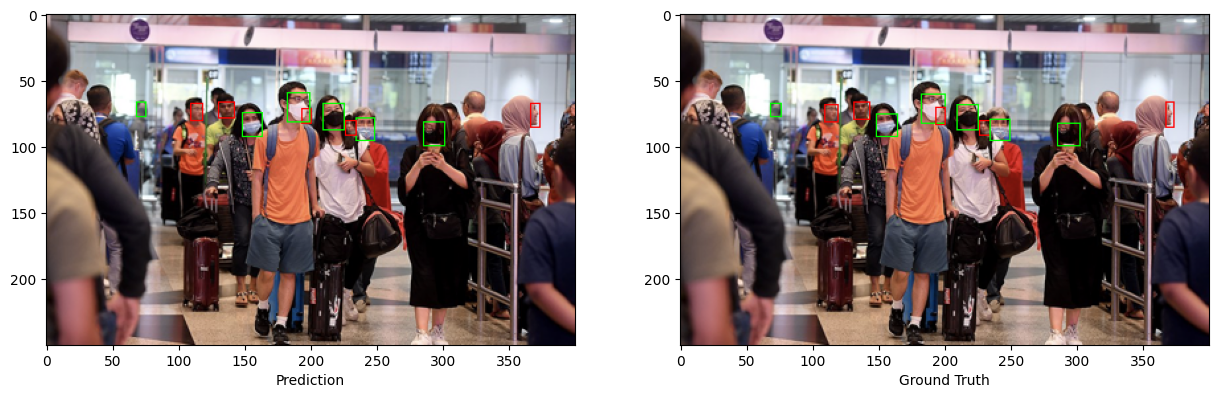

In [ ]:
# Prediction
test_img, test_boxes, test_labels = single_img_predict(test_img)
test_output = draw_boxes(test_img, test_boxes, test_labels)

# Draw the bounding box of ground truth
bbox, labels = read_annot(file_list[idx], xml_path)
gt_output = draw_boxes(test_img, bbox, labels)

# Print the predicted and ground truth labels
print("Predicted Labels:", test_labels)
print("Ground Truth Labels:", labels)

# Display the result
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.imshow(test_output)
ax1.set_xlabel('Prediction')
ax2.imshow(gt_output)
ax2.set_xlabel('Ground Truth')
plt.show()


- Lets pick an image from the training set and compare the prediction with ground truth

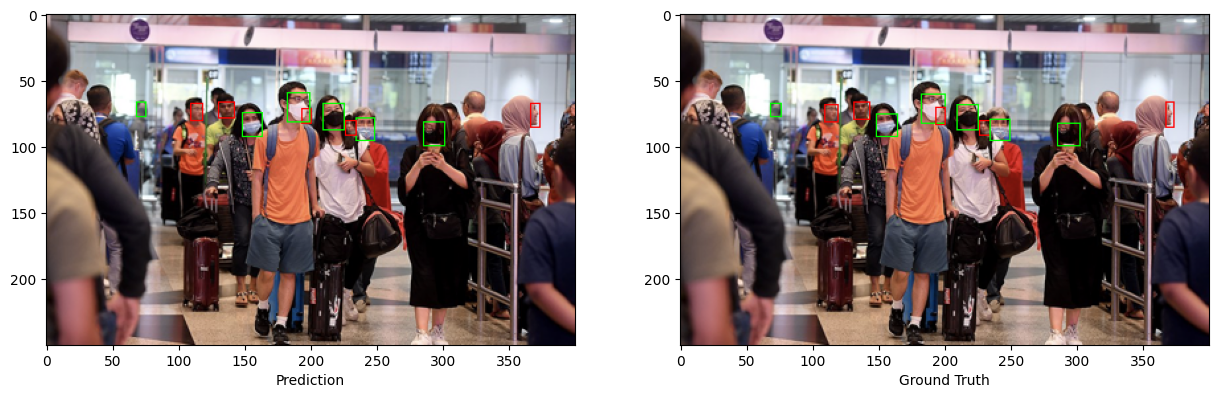

In [ ]:
#idx = random.randint(1,len(file_list))
idx = 224
test_img = Image.open(os.path.join(dir_path,file_list[idx])).convert('RGB')

# Prediction
test_img, test_boxes, test_labels = single_img_predict(test_img)
test_output = draw_boxes(test_img, test_boxes,test_labels)

# Draw the bounding box of ground truth
bbox, labels  = read_annot(file_list[idx], xml_path)
#draw bounding boxes on the image
gt_output = draw_boxes(test_img, bbox,labels)

# Display the result
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,6))
ax1.imshow(test_output)
ax1.set_xlabel('Prediction')
ax2.imshow(gt_output)
ax2.set_xlabel('Ground Truth')
plt.show()

Thank you.